<a href="https://colab.research.google.com/github/siddharth-sudhakar/K_Means_Clustering/blob/main/Marketing_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
import plotly.express as px
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import plotly.express as px
import plotly.graph_objects as go

from google.colab import files #library to upload files to colab notebook
%matplotlib inline

Mount Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Look at data

In [3]:
sales_df = pd.read_csv('/content/drive/My Drive/Marketing_AI_Project/AI in Marketing Dataset/sales_data_sample.csv', encoding = 'unicode_escape')

In [ ]:
sales_df.head()

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,...,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,...,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,...,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,10/10/2003 0:00,Shipped,4,10,2003,...,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium


In [ ]:
sales_df.dtypes

ORDERNUMBER           int64
QUANTITYORDERED       int64
PRICEEACH           float64
ORDERLINENUMBER       int64
SALES               float64
ORDERDATE            object
STATUS               object
QTR_ID                int64
MONTH_ID              int64
YEAR_ID               int64
PRODUCTLINE          object
MSRP                  int64
PRODUCTCODE          object
CUSTOMERNAME         object
PHONE                object
ADDRESSLINE1         object
ADDRESSLINE2         object
CITY                 object
STATE                object
POSTALCODE           object
COUNTRY              object
TERRITORY            object
CONTACTLASTNAME      object
CONTACTFIRSTNAME     object
DEALSIZE             object
dtype: object

In [4]:
sales_df['ORDERDATE']=pd.to_datetime(sales_df['ORDERDATE'])

In [ ]:
sales_df.dtypes

ORDERNUMBER                  int64
QUANTITYORDERED              int64
PRICEEACH                  float64
ORDERLINENUMBER              int64
SALES                      float64
ORDERDATE           datetime64[ns]
STATUS                      object
QTR_ID                       int64
MONTH_ID                     int64
YEAR_ID                      int64
PRODUCTLINE                 object
MSRP                         int64
PRODUCTCODE                 object
CUSTOMERNAME                object
PHONE                       object
ADDRESSLINE1                object
ADDRESSLINE2                object
CITY                        object
STATE                       object
POSTALCODE                  object
COUNTRY                     object
TERRITORY                   object
CONTACTLASTNAME             object
CONTACTFIRSTNAME            object
DEALSIZE                    object
dtype: object

In [ ]:
sales_df.isnull().sum()

ORDERNUMBER            0
QUANTITYORDERED        0
PRICEEACH              0
ORDERLINENUMBER        0
SALES                  0
ORDERDATE              0
STATUS                 0
QTR_ID                 0
MONTH_ID               0
YEAR_ID                0
PRODUCTLINE            0
MSRP                   0
PRODUCTCODE            0
CUSTOMERNAME           0
PHONE                  0
ADDRESSLINE1           0
ADDRESSLINE2        2521
CITY                   0
STATE               1486
POSTALCODE            76
COUNTRY                0
TERRITORY           1074
CONTACTLASTNAME        0
CONTACTFIRSTNAME       0
DEALSIZE               0
dtype: int64

Data Preprocessing

In [5]:
df_drop = ['ADDRESSLINE1','ADDRESSLINE2','POSTALCODE','CITY','TERRITORY','PHONE','STATE','CONTACTFIRSTNAME','CONTACTLASTNAME','CUSTOMERNAME','ORDERNUMBER']
sales_df = sales_df.drop(df_drop,axis = 1)
sales_df.head()

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,PRODUCTCODE,COUNTRY,DEALSIZE
0,30,95.70,2,2871.00,2003-02-24,Shipped,1,2,2003,Motorcycles,95,S10_1678,USA,Small
1,34,81.35,5,2765.90,2003-05-07,Shipped,2,5,2003,Motorcycles,95,S10_1678,France,Small
2,41,94.74,2,3884.34,2003-07-01,Shipped,3,7,2003,Motorcycles,95,S10_1678,France,Medium
3,45,83.26,6,3746.70,2003-08-25,Shipped,3,8,2003,Motorcycles,95,S10_1678,USA,Medium
4,49,100.00,14,5205.27,2003-10-10,Shipped,4,10,2003,Motorcycles,95,S10_1678,USA,Medium


In [ ]:
sales_df.nunique()

QUANTITYORDERED      58
PRICEEACH          1016
ORDERLINENUMBER      18
SALES              2763
ORDERDATE           252
STATUS                6
QTR_ID                4
MONTH_ID             12
YEAR_ID               3
PRODUCTLINE           7
MSRP                 80
PRODUCTCODE         109
COUNTRY              19
DEALSIZE              3
dtype: int64

In [6]:
def barplot_visualization(x):
    fig = plt.Figure(figsize = (12,6))
    fig = px.bar(x = sales_df[x].value_counts().index,y = sales_df[x].value_counts(),height = 600)
    fig.show()

In [ ]:
barplot_visualization('COUNTRY')

In [ ]:
barplot_visualization('STATUS')

In [7]:
sales_df.drop(columns = ['STATUS'], inplace = True)

In [ ]:
barplot_visualization('PRODUCTLINE')

In [ ]:
barplot_visualization('DEALSIZE')

In [8]:
def dummies(x):
    dummy = pd.get_dummies(sales_df[x])
    sales_df.drop(columns = x, inplace=True)
    return  pd.concat([sales_df,dummy],axis =1)

In [9]:
sales_df = dummies('COUNTRY')
sales_df

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,...,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA
0,30,95.70,2,2871.00,2003-02-24,1,2,2003,Motorcycles,95,...,0,0,0,0,0,0,0,0,0,1
1,34,81.35,5,2765.90,2003-05-07,2,5,2003,Motorcycles,95,...,0,0,0,0,0,0,0,0,0,0
2,41,94.74,2,3884.34,2003-07-01,3,7,2003,Motorcycles,95,...,0,0,0,0,0,0,0,0,0,0
3,45,83.26,6,3746.70,2003-08-25,3,8,2003,Motorcycles,95,...,0,0,0,0,0,0,0,0,0,1
4,49,100.00,14,5205.27,2003-10-10,4,10,2003,Motorcycles,95,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,20,100.00,15,2244.40,2004-12-02,4,12,2004,Ships,54,...,0,0,0,0,0,1,0,0,0,0
2819,29,100.00,1,3978.51,2005-01-31,1,1,2005,Ships,54,...,0,0,0,0,0,0,0,0,0,0
2820,43,100.00,4,5417.57,2005-03-01,1,3,2005,Ships,54,...,0,0,0,0,0,1,0,0,0,0
2821,34,62.24,1,2116.16,2005-03-28,1,3,2005,Ships,54,...,0,0,0,0,0,0,0,0,0,0


In [10]:
sales_df = dummies('PRODUCTLINE')

In [11]:
sales_df = dummies('DEALSIZE')

In [ ]:
sales_df

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,QTR_ID,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,...,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
0,30,95.70,2,2871.00,2003-02-24,1,2,2003,95,S10_1678,...,0,1,0,0,0,0,0,0,0,1
1,34,81.35,5,2765.90,2003-05-07,2,5,2003,95,S10_1678,...,0,1,0,0,0,0,0,0,0,1
2,41,94.74,2,3884.34,2003-07-01,3,7,2003,95,S10_1678,...,0,1,0,0,0,0,0,0,1,0
3,45,83.26,6,3746.70,2003-08-25,3,8,2003,95,S10_1678,...,0,1,0,0,0,0,0,0,1,0
4,49,100.00,14,5205.27,2003-10-10,4,10,2003,95,S10_1678,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,20,100.00,15,2244.40,2004-12-02,4,12,2004,54,S72_3212,...,0,0,0,1,0,0,0,0,0,1
2819,29,100.00,1,3978.51,2005-01-31,1,1,2005,54,S72_3212,...,0,0,0,1,0,0,0,0,1,0
2820,43,100.00,4,5417.57,2005-03-01,1,3,2005,54,S72_3212,...,0,0,0,1,0,0,0,0,1,0
2821,34,62.24,1,2116.16,2005-03-28,1,3,2005,54,S72_3212,...,0,0,0,1,0,0,0,0,0,1


In [12]:
y = pd.Categorical(sales_df['PRODUCTCODE'])
y

['S10_1678', 'S10_1678', 'S10_1678', 'S10_1678', 'S10_1678', ..., 'S72_3212', 'S72_3212', 'S72_3212', 'S72_3212', 'S72_3212']
Length: 2823
Categories (109, object): ['S10_1678', 'S10_1949', 'S10_2016', 'S10_4698', ..., 'S700_3962',
                           'S700_4002', 'S72_1253', 'S72_3212']

In [13]:
y = pd.Categorical(sales_df['PRODUCTCODE']).codes
y

array([  0,   0,   0, ..., 108, 108, 108], dtype=int8)

In [14]:
sales_df['PRODUCTCODE'] = pd.Categorical(sales_df['PRODUCTCODE']).codes
sales_df

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,QTR_ID,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,...,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
0,30,95.70,2,2871.00,2003-02-24,1,2,2003,95,0,...,0,1,0,0,0,0,0,0,0,1
1,34,81.35,5,2765.90,2003-05-07,2,5,2003,95,0,...,0,1,0,0,0,0,0,0,0,1
2,41,94.74,2,3884.34,2003-07-01,3,7,2003,95,0,...,0,1,0,0,0,0,0,0,1,0
3,45,83.26,6,3746.70,2003-08-25,3,8,2003,95,0,...,0,1,0,0,0,0,0,0,1,0
4,49,100.00,14,5205.27,2003-10-10,4,10,2003,95,0,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,20,100.00,15,2244.40,2004-12-02,4,12,2004,54,108,...,0,0,0,1,0,0,0,0,0,1
2819,29,100.00,1,3978.51,2005-01-31,1,1,2005,54,108,...,0,0,0,1,0,0,0,0,1,0
2820,43,100.00,4,5417.57,2005-03-01,1,3,2005,54,108,...,0,0,0,1,0,0,0,0,1,0
2821,34,62.24,1,2116.16,2005-03-28,1,3,2005,54,108,...,0,0,0,1,0,0,0,0,0,1


In [15]:
sales_df_group = sales_df.groupby(by = "ORDERDATE").sum()
sales_df_group

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,QTR_ID,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,...,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
ORDERDATE,,,,,,,,,,,,,,,,,,,,,
2003-01-06,151,288.78,10,12133.25,4,4,8012,363,174.0,0,...,0,0,0,0,0,0,4,0,2,2
2003-01-09,142,284.96,10,11432.34,4,4,8012,372,181.0,0,...,0,0,0,0,0,0,4,0,2,2
2003-01-10,80,150.14,3,6864.05,2,2,4006,155,37.0,0,...,0,0,0,0,0,0,2,0,1,1
2003-01-29,541,1417.54,136,54702.00,16,16,32048,1695,723.0,0,...,3,0,0,0,0,7,6,0,10,6
2003-01-31,443,1061.89,91,44621.96,13,13,26039,1365,720.0,0,...,7,0,0,0,2,4,0,0,8,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-05-13,259,561.18,21,31821.90,12,30,12030,728,101.0,0,...,0,6,0,0,0,0,0,2,3,1
2005-05-17,509,1269.43,105,59475.10,28,70,28070,1669,462.0,0,...,14,0,0,0,0,0,0,2,8,4
2005-05-29,607,1148.40,94,51233.18,30,75,30075,1328,797.0,13,...,7,0,0,0,0,0,8,0,8,7


In [16]:
fig = px.line(x = sales_df_group.index, y = sales_df_group.SALES, title = 'Sales')
fig.show()

In [17]:
sales_df.drop("ORDERDATE", axis = 1, inplace = True)
sales_df.shape

(2823, 38)

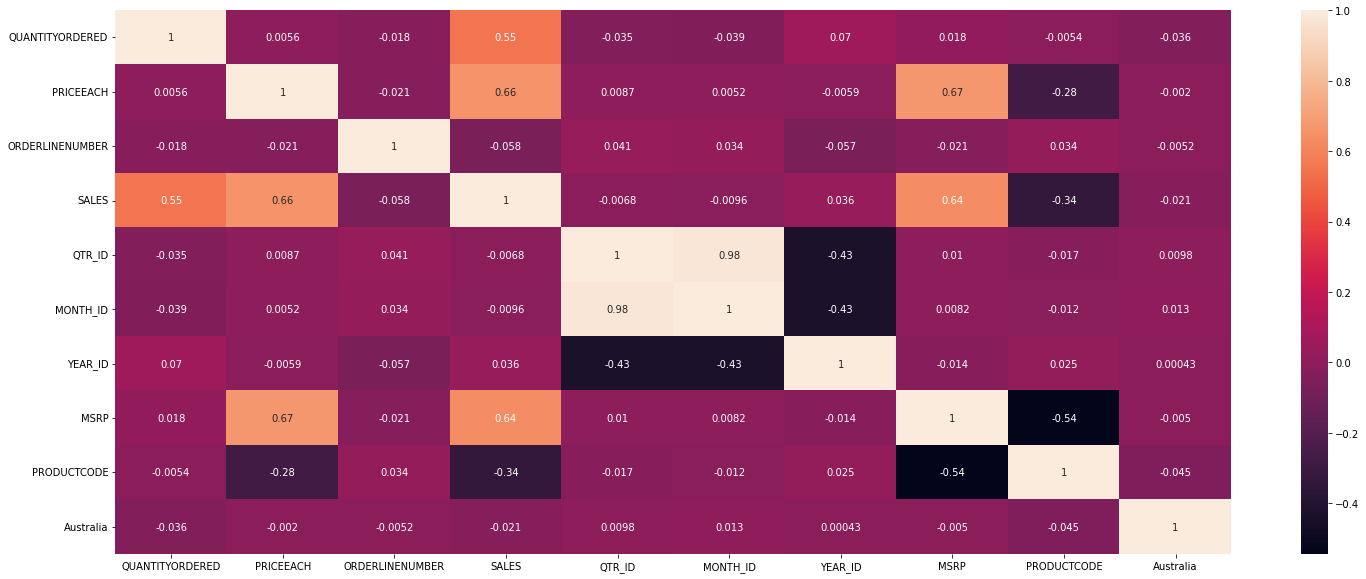

In [18]:
plt.figure(figsize = (25,10))
corr_matrix = sales_df.iloc[:,:10].corr()
sns.heatmap(corr_matrix, annot = True)

In [19]:
sales_df.drop("QTR_ID", axis = 1, inplace = True)
sales_df.shape

(2823, 37)

In [20]:
plt.figure(figsize = (15,15))
fig = px.scatter_matrix(sales_df,
                        dimensions = sales_df.columns[:8],color = 'MONTH_ID')

fig.update_layout(
    title = 'Sales Data',
    width = 1100,
    height = 1100,
)
fig.show()

<Figure size 1080x1080 with 0 Axes>

In [21]:
scaler = StandardScaler()
sales_df_scaled = scaler.fit_transform(sales_df)

In [22]:
sales_df_scaled.shape

(2823, 37)

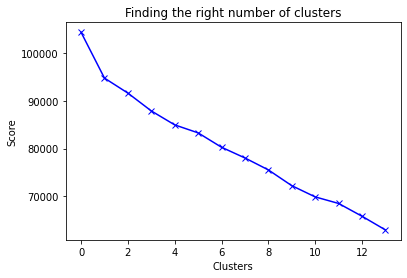

In [23]:
scores = []

range_values = range(1,15)

for i in range_values:
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(sales_df_scaled)
    scores.append(kmeans.inertia_)

plt.plot(scores,'bx-')
plt.title('Finding the right number of clusters')
plt.xlabel('Clusters')
plt.ylabel('Score')
plt.show()

In [24]:
kmeans = KMeans(5)
kmeans.fit(sales_df_scaled)
labels = kmeans.labels_

In [25]:
labels

array([2, 2, 1, ..., 4, 2, 4], dtype=int32)

In [26]:
kmeans.cluster_centers_.shape

(5, 37)

In [27]:
cluster_centers = pd.DataFrame(data = kmeans.cluster_centers_, columns = [sales_df.columns])
cluster_centers

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,...,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
0,0.081943,0.142367,-0.153367,0.065149,-0.035235,0.030410,0.055497,-0.206998,-0.264819,7.094172,...,0.236012,-0.081879,0.002237,-0.036861,-0.167454,-0.050918,-0.080814,0.074670,0.074042,-0.108712
1,-0.009677,0.728639,-0.024733,0.570740,0.130391,-0.209425,0.920673,-0.759328,-0.037731,-0.140961,...,0.714373,-0.104680,-0.302324,-0.300637,-0.167454,0.214773,-0.407630,-0.242672,0.967793,-0.860008
2,-0.458741,-0.744767,0.048788,-0.814775,0.015894,-0.006149,-0.612744,0.307903,0.031260,-0.140961,...,-0.183981,0.023460,0.076074,0.058550,0.079698,-0.040246,0.095924,-0.242672,-0.980703,1.096370
3,1.223882,0.799961,-0.268121,2.575220,-0.096798,0.114838,1.449091,-0.874499,-0.079937,-0.140961,...,0.586589,-0.019085,-0.159457,-0.300637,-0.127328,-0.197232,-0.141557,4.120788,-0.980703,-0.912100
4,0.566586,0.425774,0.008878,0.321451,-0.137679,0.196958,-0.151226,0.426717,0.020848,-0.140961,...,-0.544918,0.075013,0.205601,0.270909,0.067628,-0.097335,0.279619,-0.242672,1.019676,-0.912100


In [28]:
cluster_centers = scaler.inverse_transform(cluster_centers)
cluster_centers = pd.DataFrame(data = cluster_centers, columns = [sales_df.columns])
cluster_centers

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,...,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
0,35.890909,86.530182,5.818182,3673.864182,6.963636,2003.836364,102.945455,47.236364,1.387779e-17,1.000000e+00,...,0.454545,0.090909,0.109091,7.272727e-02,0.000000e+00,0.090909,0.181818,7.272727e-02,5.272727e-01,4.000000e-01
1,34.998559,98.355706,6.361671,4604.929121,7.569164,2003.668588,137.708934,29.793948,5.619597e-02,1.804112e-16,...,0.681556,0.083573,0.014409,9.714451e-16,1.838807e-16,0.172911,0.047550,5.412337e-16,9.740634e-01,2.593660e-02
2,30.624799,68.636079,6.672303,2053.449396,7.150564,2003.810789,76.095008,63.496779,7.326892e-02,2.220446e-16,...,0.255233,0.124799,0.132045,9.903382e-02,4.025765e-02,0.094203,0.254428,6.730727e-16,-1.054712e-15,1.000000e+00
3,47.013072,99.794314,5.333333,8296.256078,6.738562,2003.895425,158.941176,26.156863,4.575163e-02,-4.510281e-17,...,0.620915,0.111111,0.058824,-9.714451e-17,6.535948e-03,0.045752,0.156863,1.000000e+00,-7.216450e-16,1.332268e-15
4,40.611193,92.246701,6.503682,4145.852990,6.589102,2003.952872,94.639175,67.248895,7.069219e-02,8.326673e-17,...,0.083947,0.141384,0.172312,1.575847e-01,3.829161e-02,0.076583,0.329897,1.318390e-16,1.000000e+00,1.221245e-15


In [29]:
labels.shape

(2823,)

In [30]:
labels.max()

4

In [31]:
labels.min()

0

In [32]:
y_kmeans = kmeans.fit_predict(sales_df_scaled)
y_kmeans

array([4, 4, 1, ..., 1, 4, 1], dtype=int32)

In [33]:
y_kmeans.shape

(2823,)

In [34]:
sale_df_cluster = pd.concat([sales_df,pd.DataFrame({'cluster':labels})], axis = 1)
sale_df_cluster

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,...,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small,cluster
0,30,95.70,2,2871.00,2,2003,95,0,0,0,...,1,0,0,0,0,0,0,0,1,2
1,34,81.35,5,2765.90,5,2003,95,0,0,0,...,1,0,0,0,0,0,0,0,1,2
2,41,94.74,2,3884.34,7,2003,95,0,0,0,...,1,0,0,0,0,0,0,1,0,1
3,45,83.26,6,3746.70,8,2003,95,0,0,0,...,1,0,0,0,0,0,0,1,0,1
4,49,100.00,14,5205.27,10,2003,95,0,0,0,...,1,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,20,100.00,15,2244.40,12,2004,54,108,0,0,...,0,0,1,0,0,0,0,0,1,2
2819,29,100.00,1,3978.51,1,2005,54,108,0,0,...,0,0,1,0,0,0,0,1,0,4
2820,43,100.00,4,5417.57,3,2005,54,108,0,0,...,0,0,1,0,0,0,0,1,0,4
2821,34,62.24,1,2116.16,3,2005,54,108,0,0,...,0,0,1,0,0,0,0,0,1,2


In [35]:
sales_df['ORDERLINENUMBER']= sales_df['ORDERLINENUMBER'].apply(lambda x: float(x))

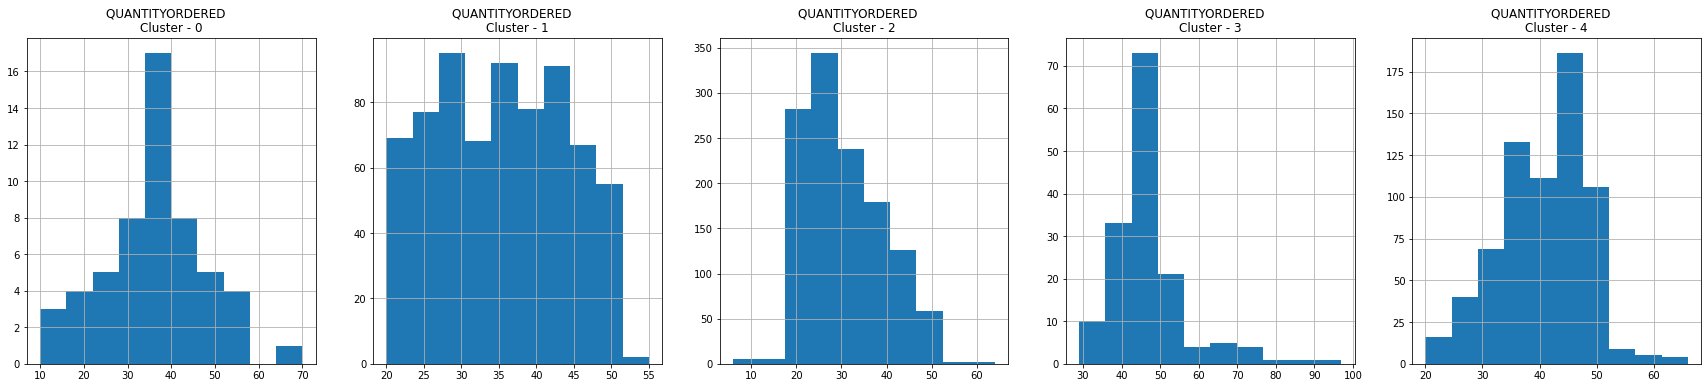

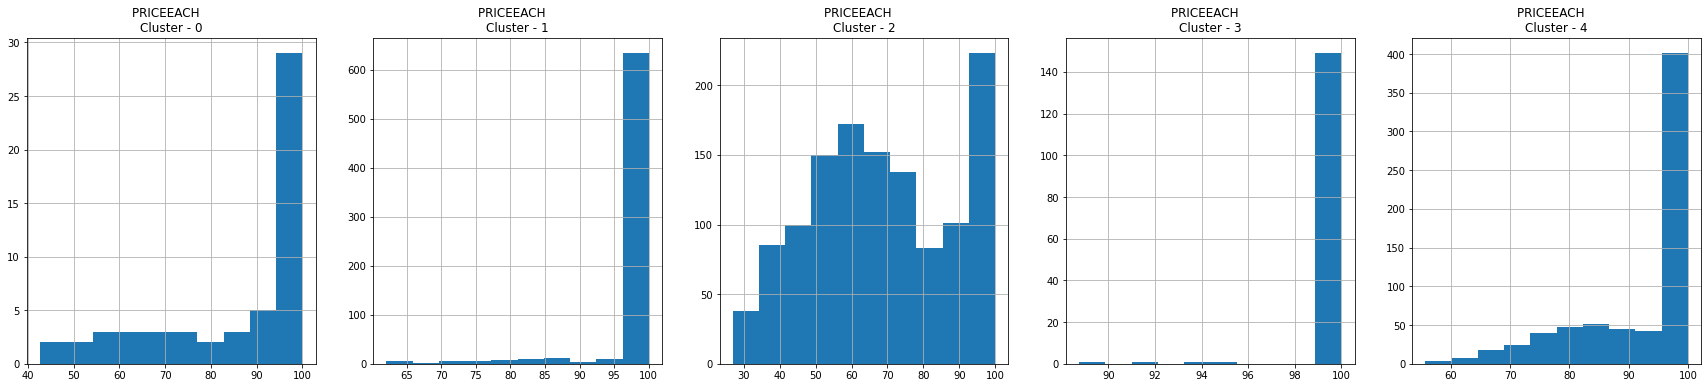

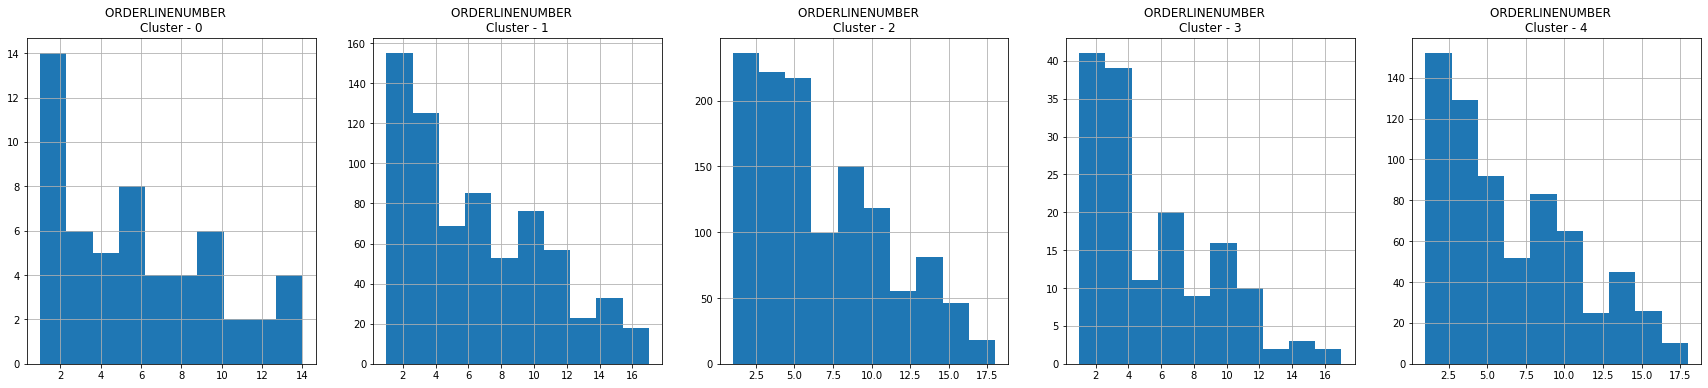

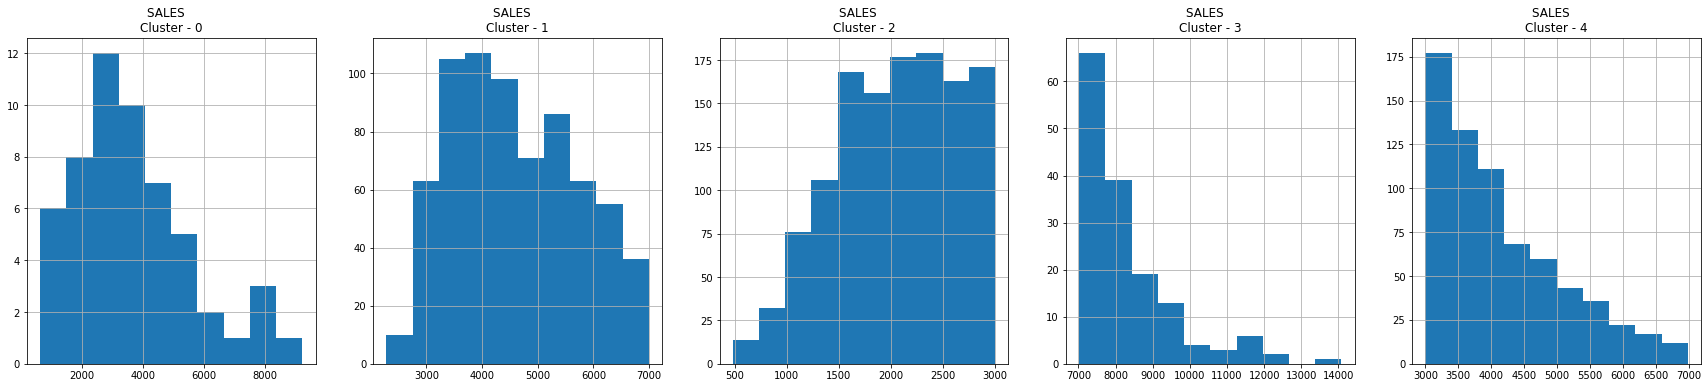

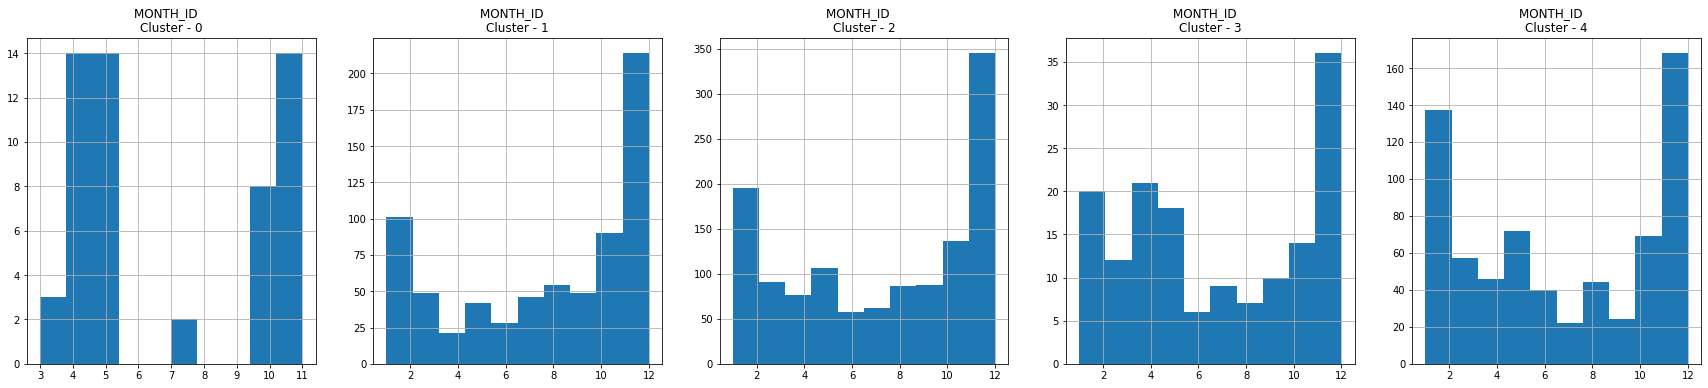

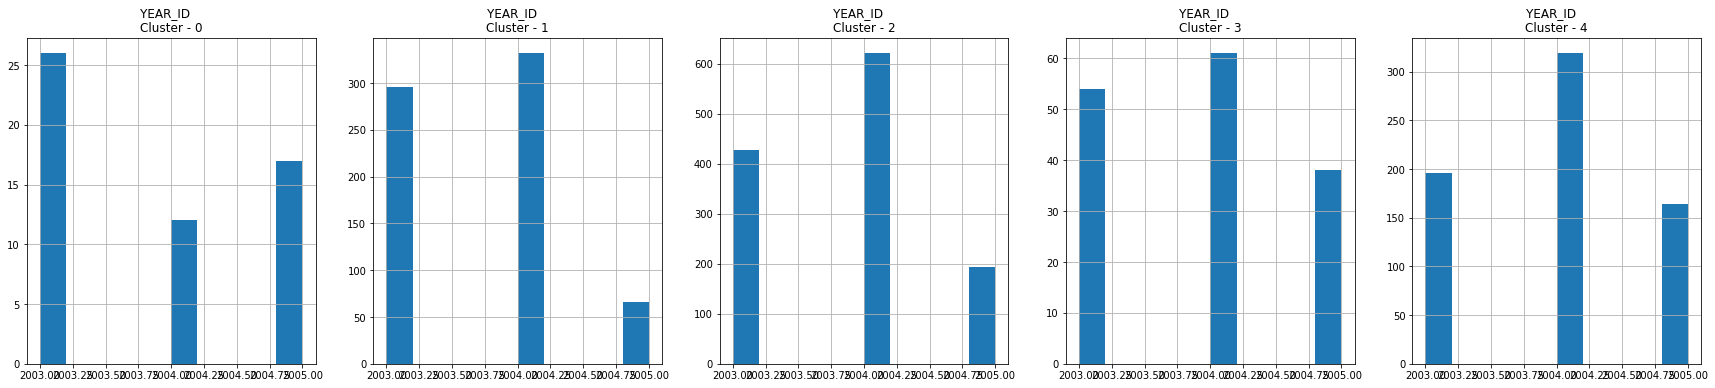

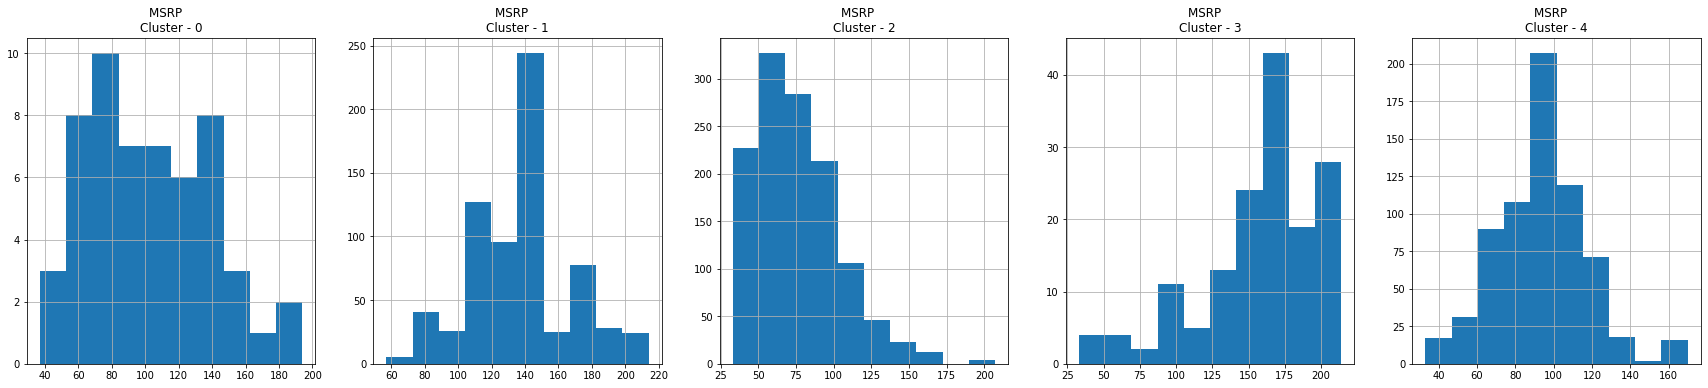

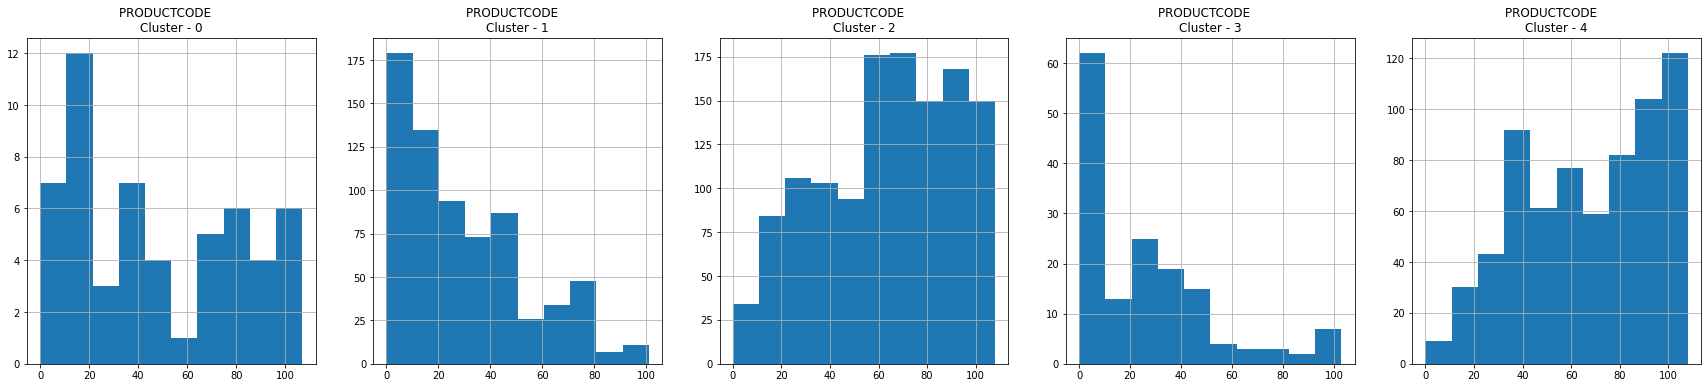

In [36]:
for i in sales_df.columns[:8]:
    plt.figure(figsize = (30,6))
    for j in range(5):
        plt.subplot(1,5,j+1)
        cluster = sale_df_cluster[sale_df_cluster['cluster']==j]
        cluster[i].hist()
        plt.title('{}   \nCluster - {}'.format(i,j))
    plt.show()

In [37]:
pca = PCA(n_components = 3)
principal_comp = pca.fit_transform(sales_df_scaled)
principal_comp

array([[-0.48631737, -1.18745897,  0.96448856],
       [-0.78474679, -0.99046686,  1.3730665 ],
       [ 1.43139185,  0.16061651,  0.24766842],
       ...,
       [ 0.3898668 ,  4.12489311, -0.05813685],
       [-2.78896084,  2.40643129,  1.54476121],
       [-0.70549329,  3.30084879, -0.51116288]])

In [38]:
pca_df = pd.DataFrame(data = principal_comp, columns = ['pca1','pca2','pca3'])
pca_df.head()

,pca1,pca2,pca3
0,-0.486317,-1.187459,0.964489
1,-0.784747,-0.990467,1.373067
2,1.431392,0.160617,0.247668
3,1.288436,-0.211888,-0.605130
4,1.976013,-0.127891,-1.092402


In [39]:
pca_df = pd.concat([pca_df, pd.DataFrame({'cluster':labels})], axis = 1)
pca_df

,pca1,pca2,pca3,cluster
0,-0.486317,-1.187459,0.964489,2
1,-0.784747,-0.990467,1.373067,2
2,1.431392,0.160617,0.247668,1
3,1.288436,-0.211888,-0.605130,1
4,1.976013,-0.127891,-1.092402,1
...,...,...,...,...
2818,-2.450349,1.128729,-1.549265,2
2819,-0.158146,3.655192,0.673840,4
2820,0.389867,4.124893,-0.058137,4
2821,-2.788961,2.406431,1.544761,2


In [40]:
fig = px.scatter_3d(pca_df, x = 'pca1', y = 'pca2', z = 'pca3',
                    color = 'cluster', symbol = 'cluster', size_max = 18, opacity = 0.7)
fig.update_layout(margin = dict(l = 0, r = 0, b = 0, t = 0))

In [41]:
sales_df.shape

(2823, 37)

In [42]:
from keras.optimizers import SGD
input_df = Input(shape = (37,))
x = Dense(50, activation = 'relu')(input_df)
x = Dense(500, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
x = Dense(500, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
x = Dense(2000, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
encoded = Dense(8, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
x = Dense(2000, activation = 'relu', kernel_initializer = 'glorot_uniform')(encoded)
x = Dense(500, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
decoded = Dense(37, kernel_initializer = 'glorot_uniform')(x)

autoencoder = Model(input_df, decoded)
encoder = Model(input_df, encoded)
autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [43]:
autoencoder.fit(sales_df,sales_df,batch_size = 128,epochs=500,verbose =3)

Epoch 1/500
Epoch 2/500
Epoch 3/500
Epoch 4/500
Epoch 5/500
Epoch 6/500
Epoch 7/500
Epoch 8/500
Epoch 9/500
Epoch 10/500
Epoch 11/500
Epoch 12/500
Epoch 13/500
Epoch 14/500
Epoch 15/500
Epoch 16/500
Epoch 17/500
Epoch 18/500
Epoch 19/500
Epoch 20/500
Epoch 21/500
Epoch 22/500
Epoch 23/500
Epoch 24/500
Epoch 25/500
Epoch 26/500
Epoch 27/500
Epoch 28/500
Epoch 29/500
Epoch 30/500
Epoch 31/500
Epoch 32/500
Epoch 33/500
Epoch 34/500
Epoch 35/500
Epoch 36/500
Epoch 37/500
Epoch 38/500
Epoch 39/500
Epoch 40/500
Epoch 41/500
Epoch 42/500
Epoch 43/500
Epoch 44/500
Epoch 45/500
Epoch 46/500
Epoch 47/500
Epoch 48/500
Epoch 49/500
Epoch 50/500
Epoch 51/500
Epoch 52/500
Epoch 53/500
Epoch 54/500
Epoch 55/500
Epoch 56/500
Epoch 57/500
Epoch 58/500
Epoch 59/500
Epoch 60/500
Epoch 61/500
Epoch 62/500
Epoch 63/500
Epoch 64/500
Epoch 65/500
Epoch 66/500
Epoch 67/500
Epoch 68/500
Epoch 69/500
Epoch 70/500
Epoch 71/500
Epoch 72/500
Epoch 73/500
Epoch 74/500
Epoch 75/500
Epoch 76/500
Epoch 77/500
Epoch 78

In [44]:
autoencoder.save_weights('autoencoder_1.h5')

In [45]:
pred = encoder.predict(sales_df_scaled)

89/89 [==============================] - 1s 12ms/step


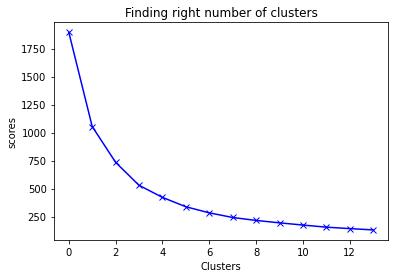

In [46]:
scores = []

range_values = range(1, 15)

for i in range_values:
  kmeans = KMeans(n_clusters = i)
  kmeans.fit(pred)
  scores.append(kmeans.inertia_)

plt.plot(scores, 'bx-')
plt.title('Finding right number of clusters')
plt.xlabel('Clusters')
plt.ylabel('scores') 
plt.show()

In [47]:
kmeans = KMeans(3)
kmeans.fit(pred)
labels = kmeans.labels_
y_kmeans = kmeans.fit_predict(sales_df_scaled)

In [48]:
df_cluster_dr = pd.concat([sales_df, pd.DataFrame({'cluster':labels})], axis = 1)

In [49]:
cluster_centers = pd.DataFrame(data = kmeans.cluster_centers_, columns = [sales_df.columns])

In [50]:
cluster_centers = scaler.inverse_transform(cluster_centers)
cluster_centers = pd.DataFrame(data = cluster_centers, columns = [sales_df.columns])

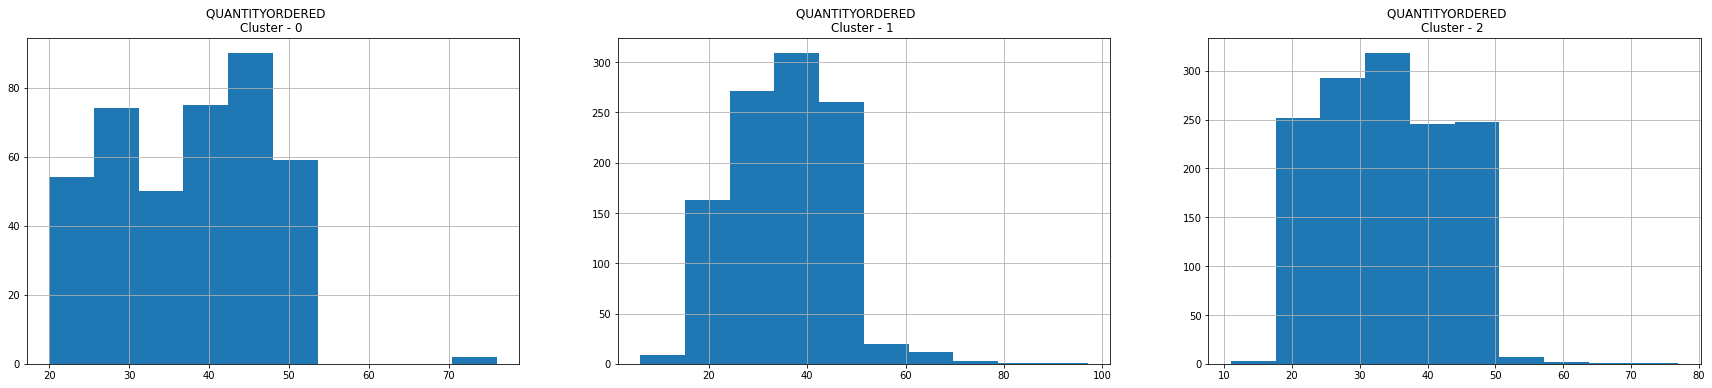

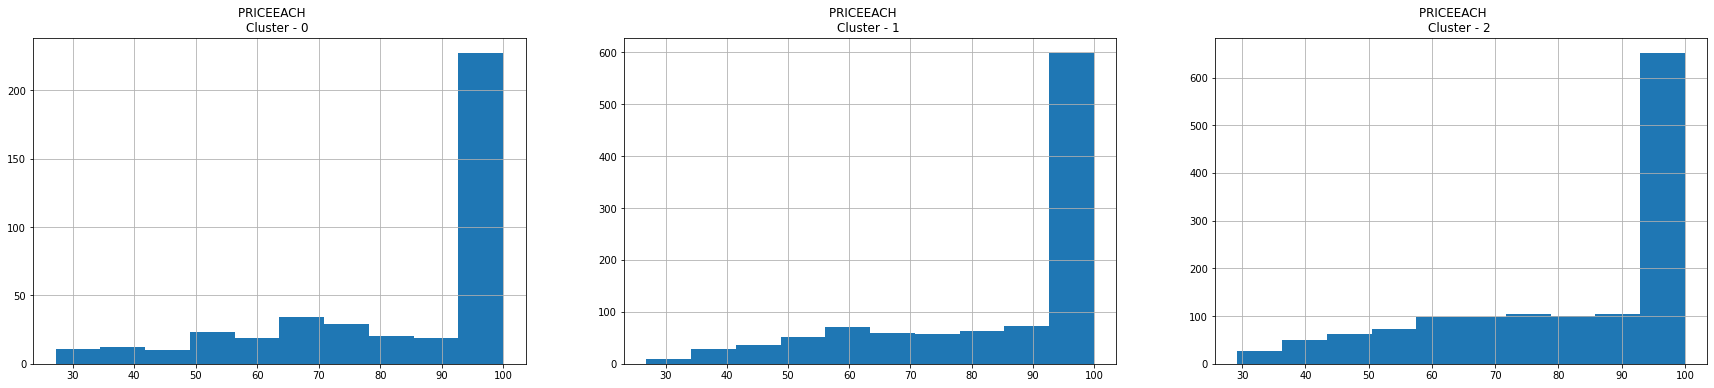

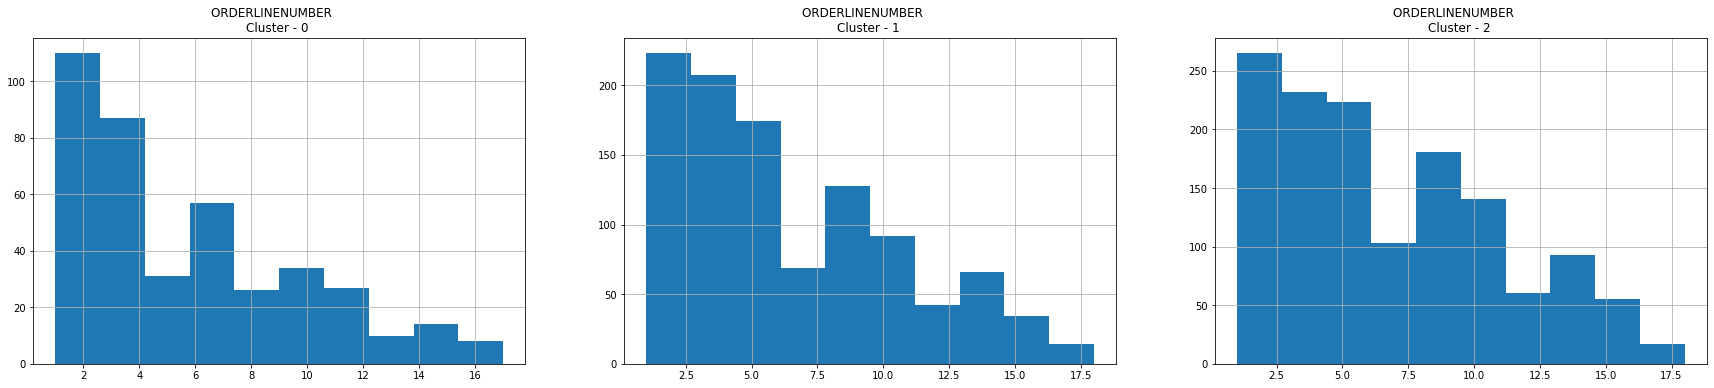

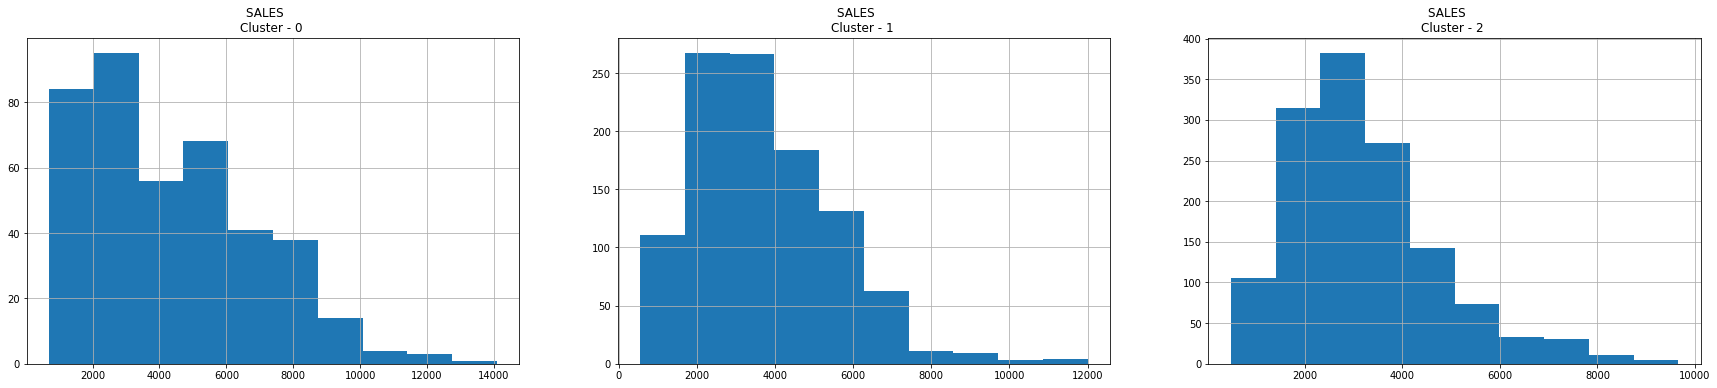

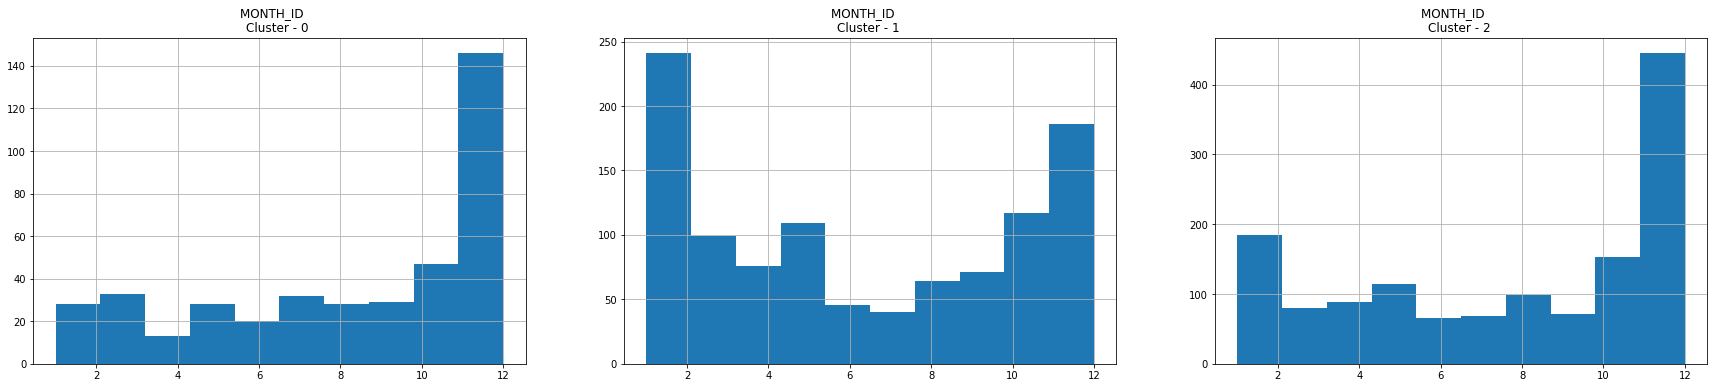

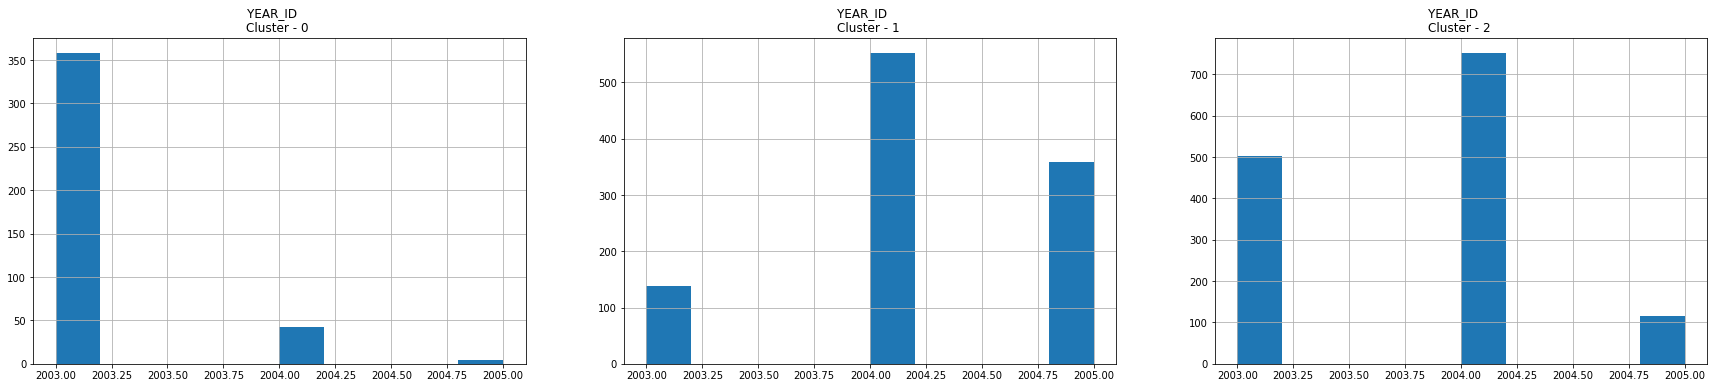

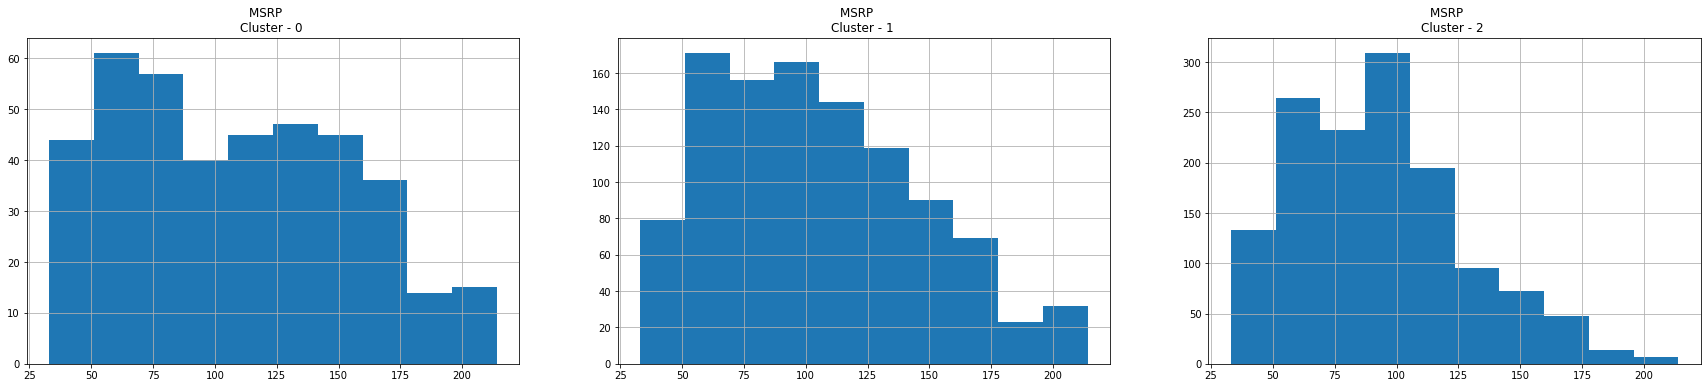

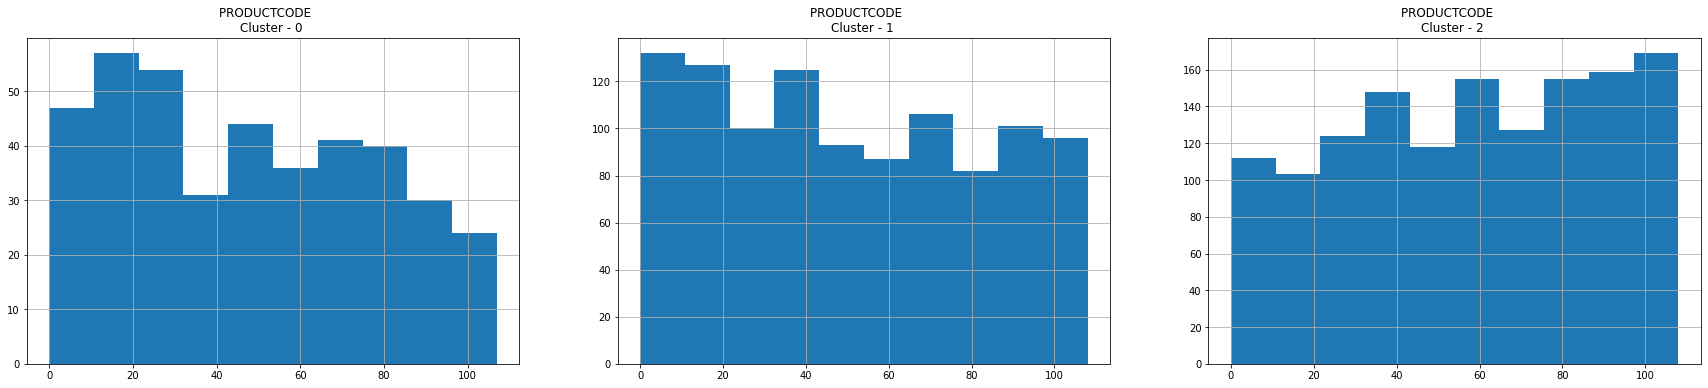

In [51]:
for i in sales_df.columns[:8]:
  plt.figure(figsize = (30, 6))
  for j in range(3):
    plt.subplot(1, 3, j+1)
    cluster = df_cluster_dr[df_cluster_dr['cluster'] == j]
    cluster[i].hist()
    plt.title('{}    \nCluster - {} '.format(i,j))
  
  plt.show()

In [52]:
pca = PCA(n_components = 3)
prin_comp = pca.fit_transform(sales_df_scaled)
pca_df = pd.DataFrame(data = prin_comp, columns = ['pca1', 'pca2', 'pca3'])
pca_df.head()

,pca1,pca2,pca3
0,-0.486221,-1.186170,1.069299
1,-0.784562,-1.033411,1.471861
2,1.431584,0.126758,0.365521
3,1.288494,-0.211122,-0.524677
4,1.976051,-0.140233,-1.047616


In [53]:
pca_df = pd.concat([pca_df, pd.DataFrame({'cluster':labels})], axis = 1)
pca_df.head()

,pca1,pca2,pca3,cluster
0,-0.486221,-1.186170,1.069299,2
1,-0.784562,-1.033411,1.471861,2
2,1.431584,0.126758,0.365521,2
3,1.288494,-0.211122,-0.524677,2
4,1.976051,-0.140233,-1.047616,2


In [54]:
# Visualize clusters using 3D-Scatterplot
fig = px.scatter_3d(pca_df, x = 'pca1', y = 'pca2', z = 'pca3',
              color='cluster', symbol = 'cluster', size_max = 10, opacity = 0.7)
fig.update_layout(margin = dict(l = 0, r = 0, b = 0, t = 0))